Simulator: Point Source
=======================

This script simulates `Positions` data of a strong lens where:

 - The lens galaxy's total mass distribution is an `EllipticalIsothermal` and `ExternalShear`.
 - The source `Galaxy` is a `PointSource`.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import numpy as np
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


The `dataset_type` describes the type of data being simulated (in this case, `Positions` data) and `dataset_name` 
gives it a descriptive name. They define the folder the dataset is output to on your hard-disk:

 - The image will be output to `/autolens_workspace/dataset/dataset_type/dataset_label/dataset_name/positions.json`.
 - The noise-map will be output to `/autolens_workspace/dataset/dataset_type/dataset_label/dataset_name/noise_map.json`.

In [2]:
dataset_type = "point_source"
dataset_name = "mass_sie__source_point"

The path where the dataset will be output, which in this case is:
`/autolens_workspace/dataset/positions/mass_sie__source_point`

In [3]:
dataset_path = path.join("dataset", dataset_type, dataset_name)

Setup the lens galaxy's mass (SIE+Shear) and source galaxy `PointSource` for this simulated lens. We include a 
faint dist in the source for purely visualization purposes to show where the multiple images appear.

For lens modeling, defining ellipticity in terms of the `elliptical_comps` improves the model-fitting procedure.

However, for simulating a strong lens you may find it more intuitive to define the elliptical geometry using the 
axis-ratio of the profile (axis_ratio = semi-major axis / semi-minor axis = b/a) and position angle phi, where phi is
in degrees and defined counter clockwise from the positive x-axis.

We can use the **PyAutoLens** `convert` module to determine the elliptical components from the axis-ratio and phi.

In [4]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllipticalIsothermal(
        centre=(0.0, 0.0),
        einstein_radius=1.6,
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.9, phi=45.0),
    ),
)

source_galaxy = al.Galaxy(
    redshift=1.0,
    light=al.lp.EllipticalExponential(
        centre=(0.0, 0.0), intensity=0.1, effective_radius=0.02
    ),
    point=al.ps.PointSource(centre=(0.0, 0.0)),
)

Use these galaxies to setup a tracer, which will compute the multiple image positions of the simulated dataset.

In [5]:
tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

We will use a `PositionSolver` to locate the multiple images. 

We will use computationally slow but robust settings to ensure we accurately locate the image-plane positions.

In [6]:
grid = al.Grid2D.uniform(
    shape_native=(100, 100),
    pixel_scales=0.05,  # <- The pixel-scale describes the conversion from pixel units to arc-seconds.
)

solver = al.PositionsSolver(
    grid=grid, use_upscaling=True, pixel_scale_precision=0.001, upscale_factor=2
)

We now pass the `Tracer` to the solver. This will then find the image-plane coordinates that map directly to the
source-plane coordinate (0.0", 0.0").

In [7]:
positions = solver.solve(
    lensing_obj=tracer, source_plane_coordinate=source_galaxy.point.centre
)

Use the positions to compute the magnification of the `Tracer` at every position.

In [8]:
magnifications = tracer.magnification_via_hessian_from_grid(grid=positions)

We can now compute the observed fluxes of the `PointSource`, give we know how much each is magnified.

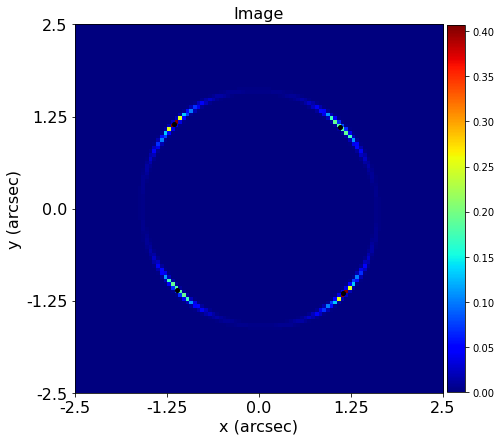

In [9]:
flux = 1.0
fluxes = [flux * np.abs(magnification) for magnification in magnifications]
fluxes = al.ValuesIrregular(values=fluxes)

visuals_2d = aplt.Visuals2D(multiple_images=positions)

tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid, visuals_2d=visuals_2d)
tracer_plotter.figures(image=True)

mat_plot_2d = aplt.MatPlot2D(
    output=aplt.Output(path=dataset_path, filename="image", format="fits")
)

tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid, mat_plot_2d=mat_plot_2d)
tracer_plotter.figures(image=True)

Output the simulated dataset to the dataset path as .fits files.

In [10]:
positions.output_to_json(
    file_path=path.join(dataset_path, "positions.json"), overwrite=True
)
fluxes.output_to_json(file_path=path.join(dataset_path, "fluxes.json"), overwrite=True)

Output a subplot of the simulated dataset, the image and a subplot of the `Tracer`'s quantities to the dataset path 
as .png files.

In [11]:
mat_plot_2d = aplt.MatPlot2D(output=aplt.Output(path=dataset_path, format="png"))

tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid, mat_plot_2d=mat_plot_2d)
tracer_plotter.subplot_tracer()


Pickle the `Tracer` in the dataset folder, ensuring the true `Tracer` is safely stored and available if we need to 
check how the dataset was simulated in the future. 

This will also be accessible via the `Aggregator` if a model-fit is performed using the dataset.

In [12]:
tracer.save(file_path=dataset_path, filename="true_tracer")

Finished.